# Pandas Plots

Pandas offers a built-in method, [`.plot()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) that allows you to generate a surprising large number of different types of plots. This method is based on the [Matplotlib](matplotlib.ipynb) Python graphic library.

In [1]:
import pandas as pd

#### Read csv files

In [2]:
from pathlib import Path

# creating a relative path to the data folder 
pth = Path('../../data')

In [3]:
# read canvas csv file into a dataframe 
canvas = pd.read_csv(pth / 'canvas.csv')

In [4]:
# read graffito
graffiti = pd.read_csv(pth/'graffiti.csv')

Before we generate plots, you will generate a new DataFrame that contains some columns from both tables. In the process of putting together this DataFrame, you will process some columns that are known to contain artifacts (e.g. quotations) and that can cause errors down the road. The columns we are interested in the new DataFrame are:   
* **canvas** : coords, property_type, surveillance, canvas_location, viewing_potential, accessibility    
* **graffito**: width, height, type, colors    

Furthermore, you want to:   
* Substitute the 'coords' column/Series by a new column called 'accuracy' derived from the former column     
* Remove any quotation marks around the surveillance, accessibility and colors columns    
* Generate a new column called 'area' that results from multiplying width and the height of each graffito    

In [5]:
# lets do an inner join
base_df =  pd.merge(canvas, graffiti, left_on='id', right_on='canvas_id', how='inner')
base_df.columns

Index(['id_x', 'created_at_x', 'uploaded_at_x', 'created_by_x', 'title_x',
       'at_canvas', 'coords', 'date_entry_canvas', 'property_type',
       'property_use', 'surveillance_status', 'surveillance',
       'canvas_location', 'canvas_nature', 'surface_material',
       'graffiti_removal', 'viewing_potential', 'accessibility', 'id_y',
       'canvas_id', 'created_at_y', 'uploaded_at_y', 'created_by_y', 'title_y',
       'num', 'date_recorded', 'width', 'height', 'type', 'technique',
       'marker_type', 'nip_type', 'other', 'num_colors', 'colors',
       'nature_graffiti', 'transcribable', 'message', 'transcription'],
      dtype='object')

In [6]:
# select only the columns we want
keep = ['coords', 'property_type', 'surveillance', 'canvas_location','viewing_potential', 'accessibility', 'width', 'height', 'type',
'colors']
sel = base_df.columns.isin(keep)
sel

array([False, False, False, False, False, False,  True, False,  True,
       False, False,  True,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False,  True, False,
       False, False, False])

In [7]:
# generate our df with only these columns
base_df= base_df.loc[:,sel]
base_df.head(3)

,coords,property_type,surveillance,canvas_location,viewing_potential,accessibility,width,height,type,colors
0,"{'latitude': 47.658577, 'longitude': -122.3176...",comercial,[],street,medium,['street_Level'],91,35,piece,"['black', 'white']"
1,"{'latitude': 47.658577, 'longitude': -122.3176...",comercial,[],street,medium,['street_Level'],91,60,piece,"['black', 'white', 'red', 'gold']"
2,"{'latitude': 47.658577, 'longitude': -122.3176...",comercial,[],street,medium,['street_Level'],25,32,tag,['white']


Accuracy information is contained within the `coords` column/Series which currently stores a Python Dictionary.

In [8]:
#  need a function to be able to extract the accuracy from coords column
from ast import literal_eval
def extract_accuracy(row, key='accuracy'):
    # convert string to dictionary
    dct = literal_eval(row)
    return dct[key]

In [9]:
# Chaining operations in order to transform our data into the table we want
base_df = (base_df.assign(accuracy= base_df.coords.apply(extract_accuracy))
              .drop(columns='coords')
              .assign(accessibility = base_df.accessibility.apply(literal_eval)) # transform accessibility
              .assign(colors = base_df.colors.apply(literal_eval)) #transform colors
              .assign(surveillance = base_df.surveillance.apply(literal_eval))
              .assign(area = base_df.width * base_df.height)

)
base_df.head(5)

,property_type,surveillance,canvas_location,viewing_potential,accessibility,width,height,type,colors,accuracy,area
0,comercial,[],street,medium,[street_Level],91,35,piece,"[black, white]",5,3185
1,comercial,[],street,medium,[street_Level],91,60,piece,"[black, white, red, gold]",5,5460
2,comercial,[],street,medium,[street_Level],25,32,tag,[white],5,800
3,comercial,[],street,medium,[street_Level],365,121,hollow,"[white, black, blue]",5,44165
4,comercial,"[cameras, lights, people, alarms]",street,medium,[street_Level],53,23,tag,[black],10,1219


In [10]:
df1 = (base_df.explode(column='surveillance')
              .fillna(value= {'surveillance':'none'})
              .pivot_table(index='property_type', columns='surveillance', aggfunc='count')['type']
              .fillna(0)
      )
df1

surveillance,alarms,cameras,dogs,guards,lights,none,other,people
property_type,,,,,,,,
comercial,83.0,370.0,63.0,26.0,504.0,169.0,2.0,476.0
government,24.0,147.0,215.0,15.0,255.0,93.0,0.0,342.0
industrial,4.0,46.0,20.0,3.0,66.0,30.0,0.0,93.0
other,0.0,14.0,0.0,0.0,15.0,11.0,0.0,17.0
public,70.0,458.0,300.0,27.0,633.0,481.0,3.0,1117.0
residential,37.0,122.0,140.0,0.0,182.0,161.0,0.0,310.0
terrain_vague,0.0,5.0,0.0,0.0,9.0,19.0,0.0,14.0


Let's generate some graphical visualizations of this information.

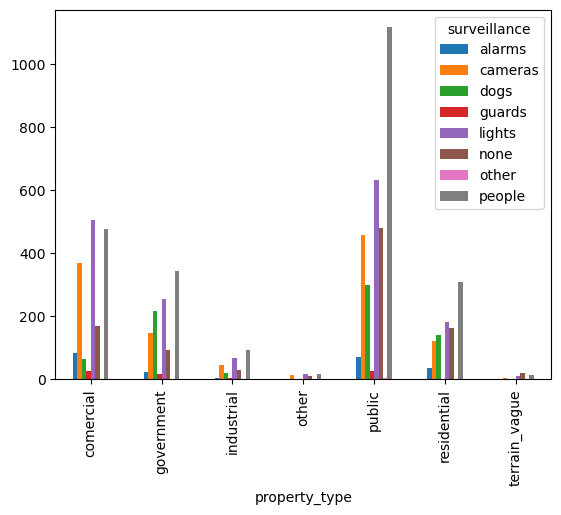

In [11]:
# Simple plot bar. Note .bar()
df1.plot.bar();

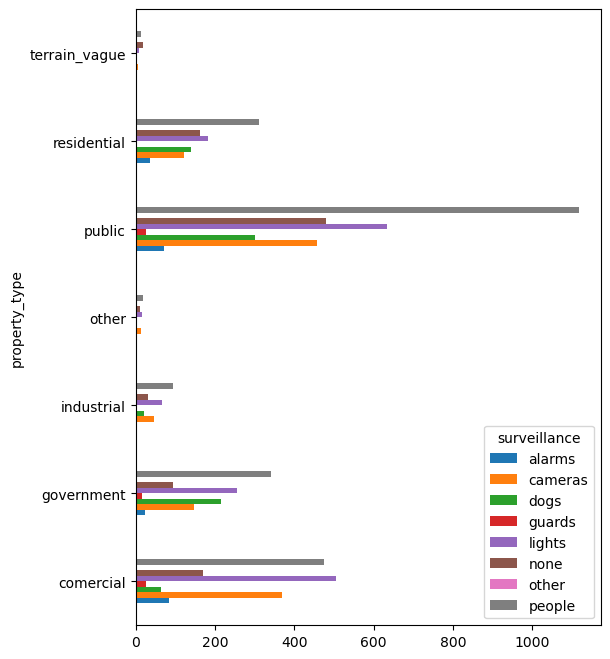

In [12]:
# horizontal bar (a bit better)
df1.plot.barh(figsize=(6,8));

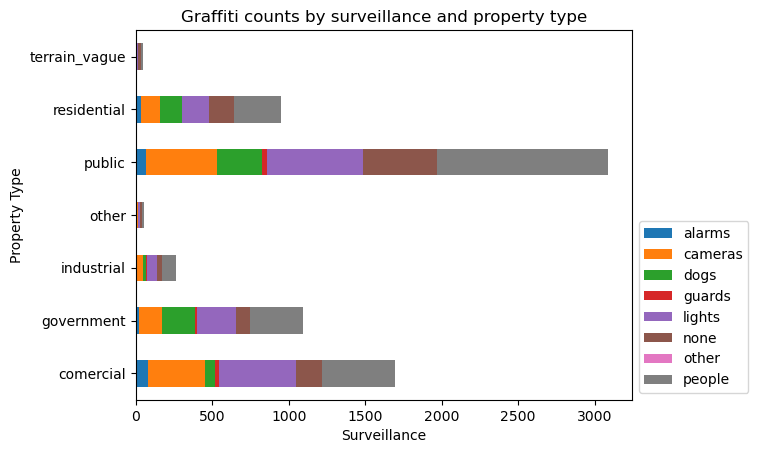

In [13]:
# horizontal stacked bar 
ax = df1.plot.barh(stacked= True, xlabel='Surveillance', ylabel='Property Type', title='Graffiti counts by surveillance and property type')
ax.legend(loc='lower left', bbox_to_anchor=(1, 0));

Let's try to improve on this... some categories are too small

In [14]:
#calculate totals for each row
totals_per_row = df1.sum(axis='columns')
totals_per_row

property_type
comercial        1693.0
government       1091.0
industrial        262.0
other              57.0
public           3089.0
residential       952.0
terrain_vague      47.0
dtype: float64

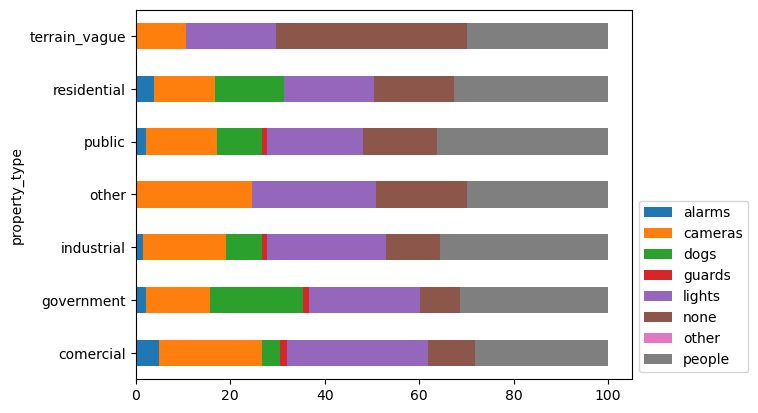

In [15]:
# create again the stacked bar chart

ax =( df1.divide(totals_per_row, axis='rows')
         .multiply(100.0)
         .round(2)
         .plot.barh(stacked=True)

)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0));

If we wanted to generate a single plot per type of surveillance,

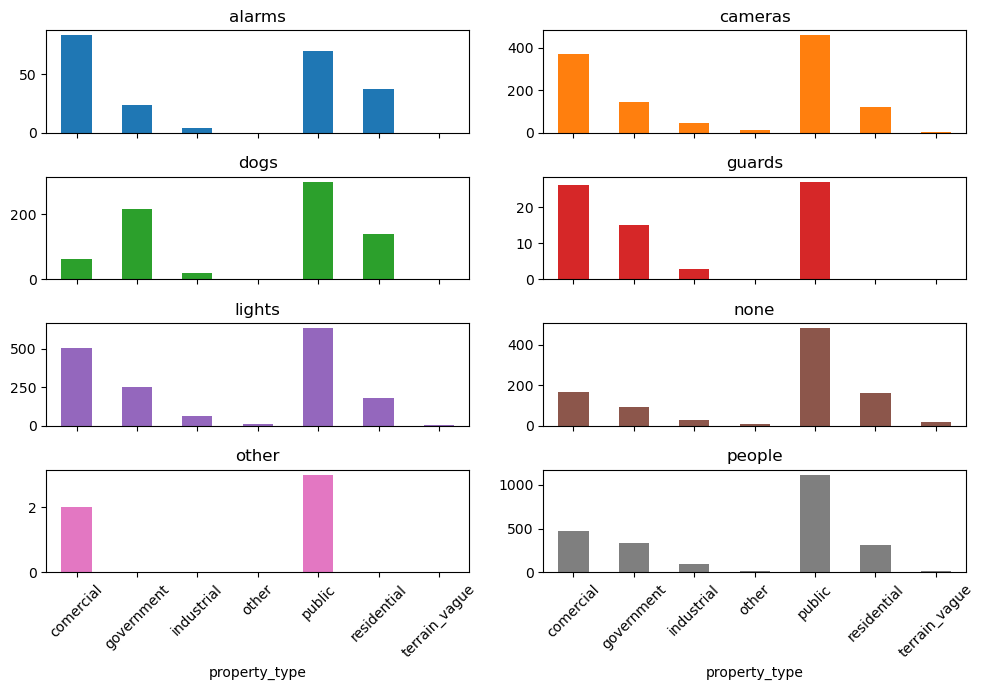

In [16]:
# subplots
import matplotlib.pyplot as plt
df1.plot.bar(subplots= True, legend= False, figsize=(10, 7), layout=(4,2) ,rot=45, sharey= False, sharex= True);
plt.tight_layout()

We want to explore the accuracy of the gps when collecting our data. We will explore this by canvas location just to see whether there are some particular locations that were problematic.

In [17]:
# Make another copy of base_df
df2 = base_df.copy(deep=True)

In [18]:
# values we have for accuracy
df2.accuracy.unique()

array([5, 10, 4, 40, 14, 7, '', 35, 22, 39, 24, 16, 15, 20, 18, 23, 17, 8,
       13, 6, 25, 11, 9, 30, 34, 31, 19, 21, 12, 36, 27, 26, 28, 53, 128,
       46, 41, 140, 29, 33, 126, 414, 37, 299, 44], dtype=object)

In [19]:
# how many undefined accuracy
sum(df2.accuracy == '')

172

Given that the whole point for this exercise is to say something about accuracy we are just going to remove those entries that do not have this information.

In [20]:
# new copy of df without unkwown accuracy entries
sel = df2.accuracy != ''
df2 = df2.loc[sel,:]
df2.accuracy.unique()

array([5, 10, 4, 40, 14, 7, 35, 22, 39, 24, 16, 15, 20, 18, 23, 17, 8, 13,
       6, 25, 11, 9, 30, 34, 31, 19, 21, 12, 36, 27, 26, 28, 53, 128, 46,
       41, 140, 29, 33, 126, 414, 37, 299, 44], dtype=object)

In [21]:
# convert into a integer type
df2['accuracy']= df2.accuracy.astype(int)

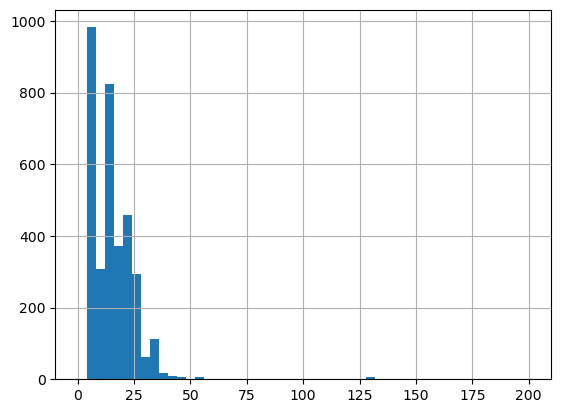

In [22]:
# histogram of the accuracy
df2.accuracy.hist(bins=50, range=(0,200));

Can we break this down by canvas location? To do this we will generate a boxplot.

In [23]:
tbl = df2.melt(id_vars='canvas_location', value_vars='accuracy')
tbl.head(5)

,canvas_location,variable,value
0,street,accuracy,5
1,street,accuracy,5
2,street,accuracy,5
3,street,accuracy,5
4,street,accuracy,10


We want to specify certain colors with particular elements in our boxplot.

In [24]:
color = {"boxes": 'LightGray', 'caps': 'white', 'medians': 'DarkRed'}

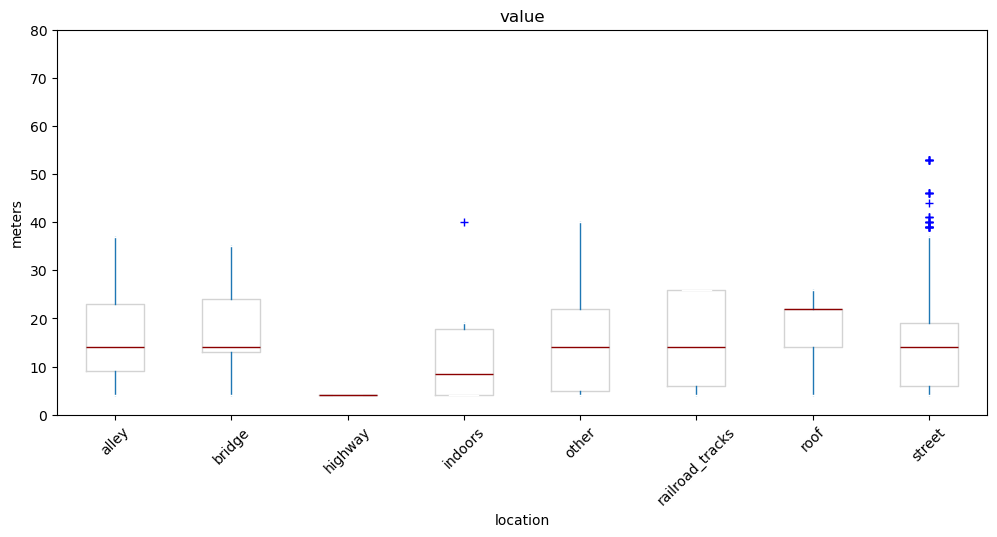

In [25]:
# generate a box plot
tbl.plot.box(by='canvas_location', figsize=(12,5), rot=45,
             ylim=(0,80),
             ylabel='meters', xlabel='location',
             sym='b+',
             color= color);